<a href="https://colab.research.google.com/github/chuktuk/Amazon_Customer_Data/blob/master/Video_Games_Flair_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Video Game Review from Amazon
Chuck Tucker

Data from
> Justifying recommendations using distantly-labeled reviews and fined-grained aspects Jianmo Ni, Jiacheng Li, Julian McAuley Empirical Methods in Natural Language Processing (EMNLP), 2019
[https://nijianmo.github.io/amazon/index.html#files](https://nijianmo.github.io/amazon/index.html#files)

This notebook is designed to run on Google Colab Pro.

### Goal for this analysis

The primary purpose of this analysis is to obtain a model that is capable of predicting positive or negative sentiment from analysis of text entries for video game reviews. 

The reviews were collected by Amazon.com by users after purchasing certain video games. More details on the data set can be obtained by visiting the link above in the 'Data from' section.

### Methods and tools

The primary text analysis tool displayed here is Flair. First, a model built-in to flair that was pretrained on IMDB reviews was assessed for accuracy on a subset of the video games data.

The result of this analysis was unsatisfactory, with extremely low precision on the negative class and an AUC of right around 0.5 (coin flip). 

Because of the poor performance of the pretrained model, a model was trained on the video games data, which produced much better results.

### Analysis

In [0]:
# check gpu info on Google Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Mar  6 12:02:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# check RAM info on Google Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [0]:
# import packages
import pandas as pd
from collections import defaultdict, deque
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

In [0]:
# install flair
!pip install flair

In [0]:
# import flair
from flair.models import TextClassifier
classifier = TextClassifier.load('en-sentiment')
from flair.data import Sentence

In [0]:
# load the video games dataset
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz

--2020-03-06 11:37:01--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154050105 (147M) [application/octet-stream]
Saving to: ‘Video_Games_5.json.gz’

Video_Games_5.json. 100%[===================>] 146.91M  10.3MB/s    in 31s     

2020-03-06 11:37:33 (4.75 MB/s) - ‘Video_Games_5.json.gz’ saved [154050105/154050105]



In [0]:
# read in the data
vg = pd.read_json('Video_Games_5.json.gz', lines=True, compression='gzip')

In [0]:
# inspect the structure
vg.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [0]:
# slice the appropriate columns
vg = vg.loc[:,['overall', 'reviewText']]

In [0]:
# clean up nan values and change datatype for memory efficiency
vg = vg.dropna(how='any')
vg.loc[:,'overall'] = vg.overall.astype('int16')

In [0]:
# map sentiment for two-class model
vg.loc[:,'pt_sentiment'] = vg.overall.map({1: 0, 2: 0, 3: 1, 4: 1, 5: 1}).astype('int16')

In [0]:
# inspect the df info
vg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497419 entries, 0 to 497576
Data columns (total 3 columns):
overall         497419 non-null int16
reviewText      497419 non-null object
pt_sentiment    497419 non-null int16
dtypes: int16(2), object(1)
memory usage: 9.5+ MB


In [0]:
# get sentiment counts
class1_counts = vg.pt_sentiment.value_counts()[1]
class0_counts = vg.pt_sentiment.value_counts()[0]
print('Positive counts {}'.format(class1_counts))
print('Negative counts {}'.format(class0_counts))

Positive counts 442407
Negative counts 55012


Because the samples were imbalanced, the majority class was downsampled to even out the classes and improve performance of model training.

In [0]:
# import resample
from sklearn.utils import resample

# down-sample to balance classes
vg_class1 = vg[vg.pt_sentiment == 1]
vg_class0 = vg[vg.pt_sentiment == 0]

# downsample majority class
vg_class1_down = resample(vg_class1, replace=False, n_samples=vg_class0.shape[0], random_state=42)

In [0]:
# concat the dfs back together
vg_down = pd.concat([vg_class1_down, vg_class0])
vg_down.pt_sentiment.value_counts()

1    55012
0    55012
Name: pt_sentiment, dtype: int64

Previous exploratory analysis revealed the presence of many special characters. These will be removed from the text prior to training.

In [0]:
# define remove chars function
import re

def rmv_spec_chars(sentence):
    sentence = re.sub("[\\\[\]@_!#$%^&*()<>?/\|}{~:']", '', sentence)
    sentence = re.sub('-', ' ', sentence)
    return sentence

In [0]:
# clean the text
vg_down.loc[:,'clean_text'] = vg_down.reviewText.apply(rmv_spec_chars)

In [0]:
# inspect the result
vg_down.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110024 entries, 388138 to 497576
Data columns (total 4 columns):
overall         110024 non-null int16
reviewText      110024 non-null object
pt_sentiment    110024 non-null int16
clean_text      110024 non-null object
dtypes: int16(2), object(2)
memory usage: 2.9+ MB


In [0]:
# indicate which text fields are now invalid due to entries that only contain
# white space after removal of special characters
vg_down.loc[:,'invalid'] = vg_down.clean_text.apply(lambda x: bool(re.match('^\s+$', x)))
vg_down.invalid.value_counts()

False    110020
True          4
Name: invalid, dtype: int64

In [0]:
# remove these from the dataset
vg_down = vg_down[vg_down.invalid == False]

In [0]:
# identify additional invalid entries that have had every character removed
# by the cleaning function (entry was entirely special characters)
vg_down.loc[:,'invalid'] = vg_down.clean_text.apply(lambda x: len(x) == 0)

In [0]:
# inspect the number of invalid entries that are empty
vg_down.invalid.value_counts()

False    109987
True         33
Name: invalid, dtype: int64

In [0]:
# remove additional invalid text entries
vg_down = vg_down[vg_down.invalid == False]

In [0]:
# classes are still approximately balanced
vg_down.pt_sentiment.value_counts()

0    55003
1    54984
Name: pt_sentiment, dtype: int64

In [0]:
# split the data into train/validation
train_text, test_text, train_labels, test_labels = train_test_split(vg_down.clean_text, 
                                                                    vg_down.pt_sentiment, 
                                                                    test_size=0.20,
                                                                    random_state=42, 
                                                                    stratify=vg_down.pt_sentiment)

In [0]:
# split the test data into test/valid
valid_text, test_text, valid_labels, test_labels = train_test_split(test_text, test_labels, 
                                                                      test_size=0.50,
                                                                      random_state=42, 
                                                                      stratify=test_labels)

The original plan was to test many different chunks if the pretrained model performance was satisfactory at each stage. 

High performance types from collections were used. Once the first chunk failed, subsequent evaluations were abandoned in interest of training a new model.

In [0]:
# testing pretrained model

In [0]:
# split the data into smaller chunks

sentences1 = deque()
sentences2 = deque()
sentences3 = deque()
sentences4 = deque()
sentences5 = deque()
test_text1 = test_text[:25000] # trying smaller size to save memory
test_text2 = test_text[25000:50000]
test_text3 = test_text[50000:75000]
test_text4 = test_text[75000:100000]
test_text5 = test_text[100000:]
print(len(test_text1) + len(test_text2) + len(test_text3) + len(test_text4) + len(test_text5))
print(len(test_text))

124355
124355


In [0]:
# extract the first chunk
for text in test_text1:
    sentences1.append(Sentence(text))

In [0]:
def get_pretrained_preds(sentences):
    
    # initialize values for loop
    scores = defaultdict(float)
    values = defaultdict(str)
    i = 0
    
    # predict for all sentences
    classifier.predict(sentences, mini_batch_size=32)
    
    # generate a list of predictions for each text entry
    while len(sentences) > 0:
        sentence = sentences.popleft()
        scores[i] = sentence.labels[0].score
        values[i] = sentence.labels[0].value
        i+=1
        
    
    # create and return a dataframe from the lists of probabilities and preditions
    df = pd.DataFrame({'probability': scores, 'prediction': values})
    return(df)

In [0]:
# create predictions for the first chunk
df_pred1 = get_pretrained_preds(sentences1)

In [0]:
# inspect the results of the pretrained model's predictions
df_pred1.head()

,probability,prediction
0,0.996104,POSITIVE
1,0.863034,POSITIVE
2,0.999872,POSITIVE
3,0.674651,POSITIVE
4,0.999235,NEGATIVE


In [0]:
# there are 25000 predictions here
df_pred1.shape

(25000, 2)

In [0]:
# map the text prediction output from the model to 0/1 for comparison to labels
df_pred1.loc[:, 'pred'] = df_pred1.prediction.map({'POSITIVE': 1, 'NEGATIVE': 0})

In [0]:
# inspect
df_pred1.head()

,probability,prediction,pred
0,0.996104,POSITIVE,1
1,0.863034,POSITIVE,1
2,0.999872,POSITIVE,1
3,0.674651,POSITIVE,1
4,0.999235,NEGATIVE,0


In [0]:
# get labels to test the accuracy
y_true1 = test_labels[:25000,]
y_pred1 = df_pred1.loc[:25000, 'pred']
print(y_true1.shape)
print(y_pred1.shape)

(25000,)
(25000,)


In [0]:
# print the confusion matrix
print(confusion_matrix(y_true1, y_pred1))
tn, fp, fn, tp = confusion_matrix(y_true1, y_pred1).ravel()
dr = tp / (tp + fn)
fpr = fp / (fp + tn)
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))
print('Detection Rate: {}'.format(dr))
print('False Positive Rate: {}'.format(fpr))

[[ 2060   681]
 [ 5285 16974]]
True Negatives: 2060
False Positives: 681
False Negatives: 5285
True Positives: 16974
Detection Rate: 0.7625679500426794
False Positive Rate: 0.24844947099598685


Over 20% of the predictions were false negatives (5285/25000). While true positives seemed to perform well, the negative predictions were very poor.

In [0]:
print(classification_report(y_true1, y_pred1))

              precision    recall  f1-score   support

           0       0.28      0.75      0.41      2741
           1       0.96      0.76      0.85     22259

    accuracy                           0.76     25000
   macro avg       0.62      0.76      0.63     25000
weighted avg       0.89      0.76      0.80     25000



The classification report illustrates the poor performance of the IMDB pretrained model on the video game reviews with a precision of 0.28 for the negative class and an F1 score of just 0.41.

In [0]:
import matplotlib.pyplot as plt

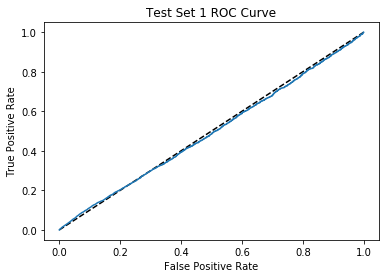

In [0]:
# generate ROC/AUC curve
y_pred_prob = df_pred1.probability

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_true1, df_pred1.probability)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='test_set_1')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Test Set 1 ROC Curve')

Yeah, so this is bad. You want to see the line going way up into the top left of this plot. Generating the integral for the area under the curve shows an AUC of right around 0.50, which is pretty horrible. 

In [0]:
# compute the AUC
print(roc_auc_score(y_true1, y_pred_prob))

0.49359414510466393


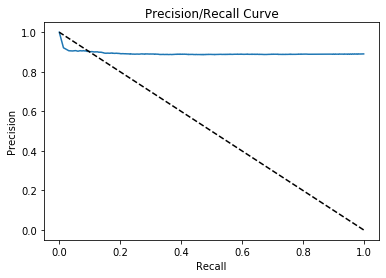

In [0]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(y_true1, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

Precision/recall is very odd, and appears to show no major decrease in precision as the recall increases. 

In [0]:
# predictions were saved in a file due to the length of time it takes to generate these predictions
df_pred1.to_csv('predictions.txt', sep=',', columns=['probability', 'prediction', 'pred'], 
                header=True, index=True, mode='w')

### Manual model training

A model was trained using the video games data to try and increase model effectiveness.

In [0]:
# manual model training

In [0]:
# write trianing data to file
# format for flair is below
# '__label__X Here is the text for the review'
# where 'X' is the label for the review (0 is negative, 1 is positive)
import os.path

idxs = train_text.index.values
max_idx = max(idxs)

if os.path.isfile('train.txt'):
    print ("File already created.")
else:
    with open('train.txt', 'w') as file:
        for idx in idxs:
            line = '__label__'
            line += str(train_labels[idx]) + ' '
            line += str.replace(train_text[idx], '\n', ' ')
            line += '\n'
            file.write(line)

In [0]:
# write dev.txt
max_idx = max(valid_text.index.values)

if os.path.isfile('dev.txt'):
    print ("File already created.")
else:
    with open('dev.txt', 'w') as file:
        for idx in valid_text.index.values:
            line = '__label__'
            line += str(valid_labels[idx]) + ' '
            line += str.replace(valid_text[idx], '\n', ' ')
            line += '\n'
            file.write(line)

In [0]:
# write test.txt
import os.path

max_idx = max(test_text.index.values)

if os.path.isfile('test.txt'):
    print ("File already created.")
else:
    with open('test.txt', 'w') as file:
        for idx in test_text.index.values:
            line = '__label__'
            line += str(test_labels[idx]) + ' '
            line += str.replace(test_text[idx], '\n', ' ')
            line += '\n'
            file.write(line)

In [0]:
# import necessary packages
from flair.data import Corpus
from flair.datasets import ClassificationCorpus
from flair.trainers import ModelTrainer
from pathlib import Path

In [0]:
# check for GPU availability
import torch
torch.cuda.is_available()

True

In [0]:
# set storage and GPU usage
import flair
device = torch.device('cuda:0')
map_location=lambda storage, loc: storage.cuda()

In [0]:
# create corpus containing training, test and dev data
corpus: Corpus = ClassificationCorpus('./',
                                      test_file='test.txt',
                                      dev_file='dev.txt',
                                      train_file='train.txt')

2020-03-06 12:04:04,963 Reading data from .
2020-03-06 12:04:04,964 Train: train.txt
2020-03-06 12:04:04,965 Dev: dev.txt
2020-03-06 12:04:04,966 Test: test.txt


In [0]:
type(corpus)

flair.datasets.ClassificationCorpus

In [0]:
# generate label dictionary
# fails if there are text entries that are invalid
# (see removal of invalid entries above)
label_dictionary=corpus.make_label_dictionary()

2020-03-06 12:04:08,825 Computing label dictionary. Progress:


100%|██████████| 87989/87989 [02:00<00:00, 728.54it/s]

2020-03-06 12:06:09,856 [b'0', b'1']


In [0]:
# import embeddings
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings
from flair.embeddings import FlairEmbeddings, DocumentRNNEmbeddings
from typing import List

In [0]:
# create word embeddings
word_embeddings = [WordEmbeddings('glove'), FlairEmbeddings('news-forward-fast'), 
                   FlairEmbeddings('news-backward-fast')]

2020-03-06 12:06:42,392 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmps22mmdnm


100%|██████████| 160000128/160000128 [00:07<00:00, 21643320.42B/s]

2020-03-06 12:06:50,340 copying /tmp/tmps22mmdnm to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2020-03-06 12:06:50,474 removing temp file /tmp/tmps22mmdnm
2020-03-06 12:06:53,690 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim not found in cache, downloading to /tmp/tmpocvo3o07


100%|██████████| 21494764/21494764 [00:01<00:00, 13293235.60B/s]

2020-03-06 12:06:55,850 copying /tmp/tmpocvo3o07 to cache at /root/.flair/embeddings/glove.gensim
2020-03-06 12:06:55,876 removing temp file /tmp/tmpocvo3o07



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


2020-03-06 12:06:58,037 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-forward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmpb0n2u7n5


100%|██████████| 19689779/19689779 [00:01<00:00, 13768414.46B/s]

2020-03-06 12:07:00,036 copying /tmp/tmpb0n2u7n5 to cache at /root/.flair/embeddings/lm-news-english-forward-1024-v0.2rc.pt
2020-03-06 12:07:00,053 removing temp file /tmp/tmpb0n2u7n5


2020-03-06 12:07:10,278 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-backward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmp5or7bv9h


100%|██████████| 19689779/19689779 [00:01<00:00, 12988348.27B/s]

2020-03-06 12:07:12,300 copying /tmp/tmp5or7bv9h to cache at /root/.flair/embeddings/lm-news-english-backward-1024-v0.2rc.pt
2020-03-06 12:07:12,320 removing temp file /tmp/tmp5or7bv9h


In [0]:
# build the RNN document embeddings
document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=512, 
                                            reproject_words=True, reproject_words_dimension=256,
                                            rnn_type='LSTM')

In [0]:
# create the classifier
classifier = TextClassifier(document_embeddings, 
                            label_dictionary=label_dictionary, 
                            multi_label=False)

In [0]:
# create a model trainer
trainer = ModelTrainer(classifier, corpus)

In [0]:
# train the model
# takes approx 12.5 hours to train on Google Colab using Pro GPU
trainer.train('./', max_epochs=10, monitor_test=True, embeddings_storage_mode='gpu')

2020-03-06 12:07:23,458 ----------------------------------------------------------------------------------------------------
2020-03-06 12:07:23,459 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25, inplace=False)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
      (list_embedding_2): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25, inplace=False)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
    )
    (word_reprojection_map): Linear(in_features=2148, out_features=256, bias=True)
    (rnn): LSTM(256, 512, b

{'dev_loss_history': [tensor(0.5849, device='cuda:0'),
  tensor(0.4969, device='cuda:0'),
  tensor(0.4762, device='cuda:0'),
  tensor(0.3954, device='cuda:0'),
  tensor(0.3654, device='cuda:0'),
  tensor(0.3657, device='cuda:0'),
  tensor(0.3486, device='cuda:0'),
  tensor(0.3410, device='cuda:0'),
  tensor(0.3136, device='cuda:0'),
  tensor(0.3091, device='cuda:0')],
 'dev_score_history': [0.7052,
  0.7824,
  0.7925,
  0.8242,
  0.8434,
  0.8413,
  0.8472,
  0.8493,
  0.8677,
  0.8698],
 'test_score': 0.8612,
 'train_loss_history': [0.6098997605605558,
  0.5576700229536403,
  0.5186884905262427,
  0.48364262035218153,
  0.43293248575925825,
  0.407481773996895,
  0.39356247357346796,
  0.38131629062782635,
  0.37357332828099077,
  0.3622117653489113]}

### Results of model training

There are several files created during model training, which will need to be saved/downloaded. The most important is 'best-model.pt' which actually contained the trained model.

The final model f1 scores were around 86% for both classes on the dev and test data, which is much better than using the pretrained model. 

The next steps are to evaluate the trained model on subsequent data, and a template for this has been laid out below.

This information will be appended to this notebook.

In [0]:
# load the best model
classifier = TextClassifier.load_from_file('./best-model.pt')

In [0]:
# create empty deque
sentences = deque()

In [0]:
# get deque of sentences
for text in test_text:
    sentences.append(Sentence(text))

In [0]:
# initialize values for loop
scores = defaultdict(float)
values = defaultdict(str)
i = 0

In [0]:
# predict for all sentences
classifier.predict(sentences, mini_batch_size=32)

In [0]:
# deque version to generate test predictions
while len(sentences) > 0:
    sentence = sentences.popleft()
    scores[i] = sentence.labels[0].score
    values[i] = sentence.labels[0].value
    i+=1

In [0]:
# convert to dataframe
df1 = pd.DataFrame({'probability': scores, 'prediction': values})